# Setup notebook

In [ ]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Add, Concatenate, Dense, GlobalAveragePooling2D, Multiply, Lambda
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, Reshape, Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import random
from tensorflow.keras.regularizers import l2

%matplotlib inline


seed = 42
random.seed(seed)  # Imposta il seed per il modulo random
np.random.seed(seed)  # Imposta il seed per numpy
tf.random.set_seed(seed)

BATCH_SIZE = 64
batch_size=64

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
tf.get_logger().setLevel('ERROR')
sys.stderr = open(os.devnull, 'w')

# Load data and augmentation

In [ ]:
training_data = np.load("/kaggle/input/mars-for-student-2/mars_for_students_cleaned_compressed (1).npz")
images = training_data["images"]/255
labels = training_data["labels"]

num_classes = 2

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

def transform_labels(y):
    return np.where(y == 4, 1, 0)

# Trasformiamo le etichette per il training e la validazione
y_train = transform_labels(y_train)
y_val = transform_labels(y_val)

In [ ]:
"add_channel"
def add_channel(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    return image, label

def add_channel_lambda(dataset):
    return dataset.map(
                        lambda x, y: add_channel(x, y),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"Flip Left Right"
@tf.function
def random_flip_left_right(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
        lambda: (image, label)
    )

    return image, label

def random_flip_left_right_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_flip_left_right(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"Flip Up Down"
@tf.function
def random_flip_up_down(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.flip_up_down(image), tf.image.flip_up_down(label)),
        lambda: (image, label)
    )

    return image, label

def random_flip_up_down_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_flip_up_down(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"Translation"
@tf.function
def translation(image, label):
    max_translation = 0.5

    # Dimensioni dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Calcolo massimo spostamento in base alla percentuale specificata
    max_dx = tf.cast(max_translation * tf.cast(width, tf.float32), tf.int32)
    max_dy = tf.cast(max_translation * tf.cast(height, tf.float32), tf.int32)

    # Generazione spostamenti casuali
    dx = tf.random.uniform([], -max_dx, max_dx + 1, dtype=tf.int32)
    dy = tf.random.uniform([], -max_dy, max_dy + 1, dtype=tf.int32)

    # Funzione per lo shift con riempimento a zero
    def zero_fill_translation():
        white_image = tf.ones((64, 128, 1), dtype=tf.float32)
        padded_image = tf.image.pad_to_bounding_box(white_image, max_dy, max_dx, height + 2 * max_dy, width + 2 * max_dx)
        cropped_image = tf.image.crop_to_bounding_box(padded_image, max_dy - dy, max_dx - dx, height, width)
        padded_label = tf.image.pad_to_bounding_box(white_image, max_dy, max_dx, height + 2 * max_dy, width + 2 * max_dx)
        cropped_label = tf.image.crop_to_bounding_box(padded_label, max_dy - dy, max_dx - dx, height, width)
        return image*cropped_image, label*cropped_label

    # Funzione per lo shift con riflessione
    def reflection_translation():
        translated_image = tf.roll(image, shift=[dy, dx], axis=[0, 1])
        translated_label = tf.roll(label, shift=[dy, dx], axis=[0, 1])
        return translated_image, translated_label

    # Decide casualmente tra riflessione o riempimento di zeri
    use_reflection = tf.random.uniform([], 0, 1) < 0.8
    translated_image, translated_label = tf.cond(
        use_reflection,
        true_fn=reflection_translation,
        false_fn=zero_fill_translation
    )

    return translated_image, translated_label


@tf.function
def random_translation(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (translation(image, label)),
        lambda: (image, label)
    )
    return image, label

def translation_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_translation(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [ ]:
"zoom"
@tf.function
def zoom(image, label, zoom_range=(0.8, 1.2)):
    # Genera un fattore di zoom casuale
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])

    # Ottieni le dimensioni originali
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]

    # Calcola le nuove dimensioni dopo lo zoom
    new_height = tf.cast(tf.cast(original_height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(original_width, tf.float32) * zoom_factor, tf.int32)

    # Ridimensiona l'immagine e la maschera
    zoomed_image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    zoomed_label = tf.image.resize(label, [new_height, new_width], method='bilinear')  # Per maschere, meglio 'nearest'

    # Ritaglia o pad per riportare alle dimensioni originali
    cropped_image = tf.image.resize_with_crop_or_pad(zoomed_image, original_height, original_width)
    cropped_label = tf.image.resize_with_crop_or_pad(zoomed_label, original_height, original_width)

    return cropped_image, cropped_label

@tf.function
def random_zoom(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (zoom(image, label)),
        lambda: (image, label)
    )
    return image, label

def zoom_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_zoom(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [ ]:
"Cutout"
@tf.function
def cutout(image, label):
    # Calcola altezza e larghezza dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]


    # Genera la dimensione del quadrato
    square_size = tf.random.uniform([], 15, 48 + 1, dtype=tf.int32)

    # Genera la posizione del quadrato
    max_x = tf.maximum(0, width - square_size)
    max_y = tf.maximum(0, height - square_size)

    start_x = tf.random.uniform([], 0, max_x + 1, dtype=tf.int32)
    start_y = tf.random.uniform([], 0, max_y + 1, dtype=tf.int32)

    # Crea una maschera per "cancellare" il quadrato
    mask = tf.ones_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(tf.meshgrid(
            tf.range(start_y, start_y + square_size),
            tf.range(start_x, start_x + square_size)
        ), axis=-1),
        updates=tf.zeros([square_size, square_size, tf.shape(image)[-1]], dtype=image.dtype)
    )

    # Applica la maschera a immagine e label
    zeroed_image = image * mask
    zeroed_label = label * mask

    return zeroed_image, zeroed_label

@tf.function
def random_cutout(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: cutout(image,label),
        lambda: (image, label)
    )
    return image, label

def cutout_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_cutout(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )



In [ ]:
"contrast"
@tf.function
def random_contrast(image, label, thr):
    prob = tf.random.uniform([], seed=seed)
    factor = tf.random.uniform([], minval=-4, maxval=4, seed=seed)


    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.adjust_contrast(image, factor), label),
        lambda: (image, label)
    )
    return image, label

def contrast_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_contrast(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [ ]:
"rotate"
@tf.function
def rotate(image, label, max_angle=30):
    """
    Ruota l'immagine e la sua maschera di un angolo casuale tra -max_angle e +max_angle gradi.

    Parametri:
    - image: Tensor, immagine di input (64, 128, 1).
    - label: Tensor, maschera associata (64, 128, 1).
    - max_angle: int, angolo massimo di rotazione (default 30 gradi).

    Ritorna:
    - image, label: immagine e maschera ruotate.
    """
    # Genera un angolo casuale tra -max_angle e +max_angle (in gradi)
    angle = tf.random.uniform([], minval=-max_angle, maxval=max_angle, dtype=tf.float32)

    # Converte l'angolo in radianti
    angle_rad = angle * tf.constant(np.pi / 180, dtype=tf.float32)  # Converte in radianti

    # Crea la matrice di trasformazione affine per la rotazione
    rotation_matrix = tf.stack([
        tf.cos(angle_rad), -tf.sin(angle_rad), 0.0,
        tf.sin(angle_rad), tf.cos(angle_rad), 0.0,
        0.0, 0.0, 1.0
    ])

    # Applica la trasformazione affine all'immagine e alla maschera
    image = tf.image.transform(image, rotation_matrix, interpolation='BILINEAR')
    label = tf.image.transform(label, rotation_matrix, interpolation='NEAREST')

    return image, label

@tf.function
def random_rotate(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (rotate(image, label)),
        lambda: (image, label)
    )
    return image, label


def rotate_lambda(dataset, thr):
    """
    Applica la rotazione casuale continua a tutte le immagini e maschere di un dataset.

    Parametri:
    - dataset: tf.data.Dataset, dataset da trasformare.
    - max_angle: int, angolo massimo di rotazione (default 30 gradi).

    Ritorna:
    - Dataset con rotazione casuale applicata.
    """
    return dataset.map(
        lambda x, y: random_rotate(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [ ]:
"multiply"
def multiply_dataset(images, labels, quantity = 1):
        indices = [i for i in range(len(labels)) if 4 in labels[i]]

        # Seleziona le immagini e le etichette corrispondenti
        images2 = images[indices]
        labels2 = labels[indices]

        images = np.concatenate([images, images[:quantity], images[:quantity], images[:quantity],images[:quantity], images2, images2, images2, images2], axis=0)
        labels = np.concatenate([labels, labels[:quantity], labels[:quantity], labels[:quantity],labels[:quantity], labels2, labels2, labels2, labels2], axis=0)
        return (images, labels)

In [ ]:
"cutmix"
def paste_patch(image, label, patch_image, patch_label, patch_size=(32, 32)):
    """Incolla una porzione (patch) di un'altra immagine e label nella posizione casuale dell'immagine corrente."""
    h, w = patch_size
    img_h, img_w = image.shape[:2]

    # Definisci la posizione casuale dove incollare la patch
    top = np.random.randint(0, img_h - h, seed = seed)
    left = np.random.randint(0, img_w - w, seed = seed)

    # Incolla la patch sull'immagine
    image[top:top+h, left:left+w] = patch_image[:h, :w]
    label[top:top+h, left:left+w] = patch_label[:h, :w]

    return image, label

def data_augmentation_fn(image, label, batch_idx, patch_size=(32, 32), frequency=2):
    """Applica l'operazione di incolla una patch ogni 'frequency' batch."""
    if batch_idx % frequency == 0:
        # Seleziona una porzione casuale da un'altra immagine del dataset
        idx = np.random.randint(0, len(X_train))  # Scegli un'altra immagine casuale dal dataset
        patch_image = X_train[idx]
        patch_label = y_train[idx]

        # Incolla la patch sull'immagine e sulla label
        image, label = paste_patch(image, label, patch_image, patch_label, patch_size)

    return image, label




def cutmix_dataset(X_train, y_train):
    # Estrai indici casuali senza ripetizione
    indices = np.random.choice(len(X_train), size=len(X_train), replace=False)

    # Crea un array per le immagini e le etichette aggiornate
    X_cutmix = np.copy(X_train)
    y_cutmix = np.copy(y_train)

    # Impostiamo la dimensione della porzione da tagliare e incollare (ad esempio 50x50 pixel)
    height, width = X_train.shape[1:]  # dimensioni delle immagini
    cut_size = 50  # altezza e larghezza della porzione da incollare

    for i in range(len(X_train)):
        # Selezioniamo una porzione casuale di dimensioni cut_size x cut_size in X_random[i]
        x_offset = np.random.randint(0, width - cut_size)
        y_offset = np.random.randint(0, height - cut_size)

        # Estrai la porzione dall'immagine X_random[i]
        X_patch = X_train[indices[i], y_offset:y_offset+cut_size, x_offset:x_offset+cut_size]
        y_patch = y_train[indices[i], y_offset:y_offset+cut_size, x_offset:x_offset+cut_size]

        # Incolla la porzione nell'immagine X_train[i]
        X_cutmix[i, y_offset:y_offset+cut_size, x_offset:x_offset+cut_size] = X_patch
        y_cutmix[i, y_offset:y_offset+cut_size, x_offset:x_offset+cut_size] = y_patch
    return X_cutmix, y_cutmix

In [ ]:
def to_dataset(X_train, y_train, augmentation = False, shuffle = False, batch_size = BATCH_SIZE, duplicate = False, cycles = 1, strange = True):
    if duplicate:
        X_train, y_train = multiply_dataset(X_train, y_train, len(X_train))
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2)

    dataset = add_channel_lambda(dataset)

    if augmentation:
        if strange:
            dataset = cutout_lambda(dataset,1)
        dataset = random_flip_left_right_lambda(dataset,0.5)
        dataset = random_flip_up_down_lambda(dataset,0.5)
        dataset = translation_lambda(dataset,0.5)
        dataset = zoom_lambda(dataset,0.5)


    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def transform_labels(y):
    return np.where(y == 0, 0, 1)

In [ ]:
train_dataset = to_dataset(X_train, y_train, augmentation = True, duplicate = True, strange = True)
val_dataset = to_dataset(X_val, y_val, augmentation = True, duplicate = True, strange = False)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_datasets(train_dataset_no_aug, train_dataset_aug, num_samples=5):
    """
    Funzione che stampa immagini e maschere da due dataset con 4 colonne:
    1. Immagini non augmentate
    2. Masks non augmentate
    3. Immagini augmentate
    4. Masks augmentate

    Parametri:
    - train_dataset_no_aug: Dataset TensorFlow non augmentato
    - train_dataset_aug: Dataset TensorFlow augmentato
    - num_samples: Numero di campioni da stampare
    """
    # Ottieni batch dai dataset senza consumarli
    no_aug_batch = list(train_dataset_no_aug.take(1).as_numpy_iterator())[0]
    aug_batch = list(train_dataset_aug.take(1).as_numpy_iterator())[0]

    # Divide immagini e maschere
    no_aug_images, no_aug_masks = no_aug_batch
    aug_images, aug_masks = aug_batch

    # Converte batch in array (se necessario)
    no_aug_images = no_aug_images[:num_samples]
    no_aug_masks = no_aug_masks[:num_samples]
    aug_images = aug_images[:num_samples]
    aug_masks = aug_masks[:num_samples]

    # Creazione della mappa di colori per le mask
    colors = ['black', 'blue', 'green', 'yellow', 'red']  # Colori per i valori da 0 a 4
    cmap = ListedColormap(colors)

    # Plot delle immagini
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        # Colonna 1: Immagini non augmentate
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(no_aug_images[i], cmap="gray")
        plt.axis("off")
        plt.title("Image (no aug)")

        # Colonna 2: Masks non augmentate
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(no_aug_masks[i], cmap=cmap, vmin=0, vmax=4)
        plt.axis("off")
        plt.title("Mask (no aug)")

        # Colonna 3: Immagini augmentate
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(aug_images[i], cmap="gray")
        plt.axis("off")
        plt.title("Image (aug)")

        # Colonna 4: Masks augmentate
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(aug_masks[i], cmap=cmap, vmin=0, vmax=4)
        plt.axis("off")
        plt.title("Mask (aug)")

    plt.tight_layout()
    plt.show()


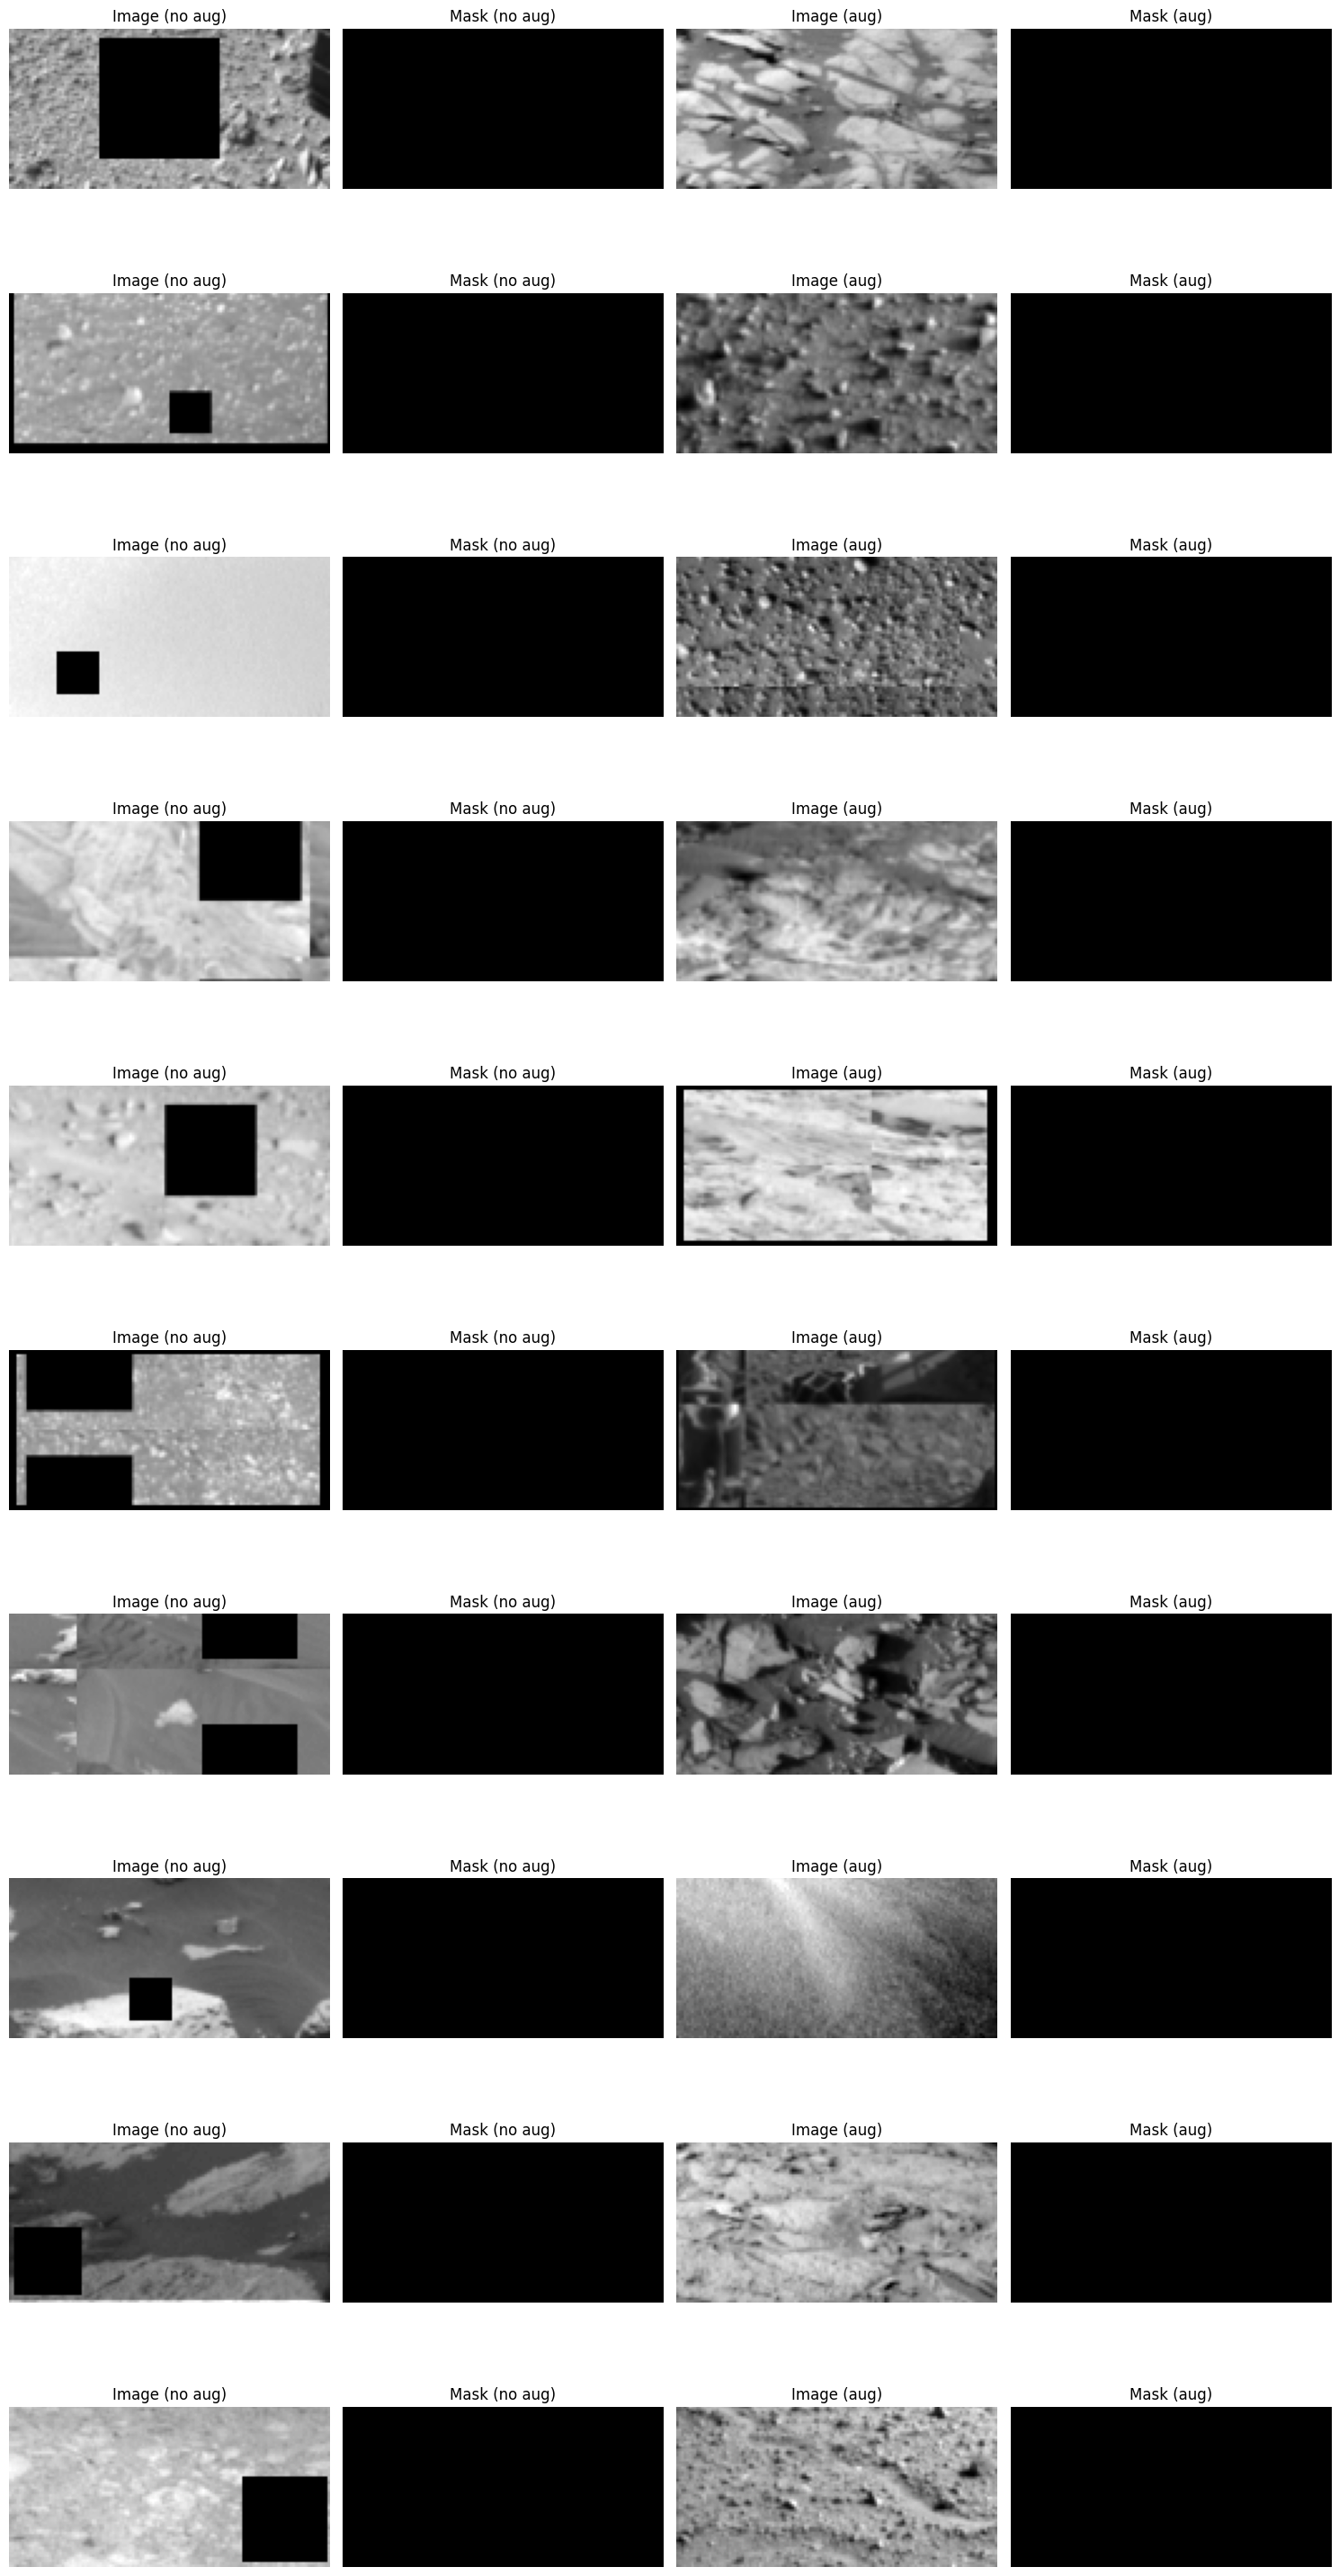

In [ ]:
plot_datasets(train_dataset, val_dataset, num_samples = 10)

# Losses definition

In [ ]:
num_classes = num_classes
epoch = 1000
patience = 50

In [ ]:
labels_flat = y_train.reshape(-1)  # Appiattisci l'array per considerare tutti i pixel

# Conta la frequenza di ogni classe
num_classes = num_classes  # Modifica in base al numero di classi nel tuo dataset
labels_flat = labels_flat.astype(int)  # Converte i dati in interi

# Conta la frequenza di ogni classe
class_frequencies = np.bincount(labels_flat, minlength=num_classes)

# Stampa le frequenze
print(f"Frequenze delle classi: {class_frequencies}")

total_samples = np.sum(class_frequencies)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)
print(f"Pesi di classe: {class_weights}")

# Conversione in dizionario per TensorFlow
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Funzione di perdita con pesi di classe
loss = tf.keras.losses.SparseCategoricalCrossentropy()

Frequenze delle classi: [16395439    21329]
Pesi di classe: [  0.50065046 384.84617188]


In [ ]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable(package="Custom", name="ComboLoss")
class ComboLoss:
    def __init__(self, alpha=0.5, dice_smooth=1e-7, class_weights=None):
        self.alpha = alpha
        self.dice_smooth = dice_smooth
        self.class_weights = class_weights

    def dice_loss(self, y_true, y_pred):
        y_true = tf.cast(tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1]), tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        cardinality = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
        dice = (2. * intersection + self.dice_smooth) / (cardinality + self.dice_smooth)
        return 1 - tf.reduce_mean(dice)

    def weighted_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)  # Assicurati che i valori siano interi
        weights = tf.gather(class_weights, y_true)  # Recupera i pesi in base alle etichette
        weights = tf.cast(weights, tf.float32)  # Converte i pesi in float32
        unweighted_loss = loss(y_true, y_pred)
        weighted_loss = unweighted_loss * weights
        return tf.reduce_mean(weighted_loss)

    def __call__(self, y_true, y_pred):
        wce = self.weighted_loss(y_true, y_pred)
        dice = self.dice_loss(y_true, y_pred)
        return self.alpha * wce + (1 - self.alpha) * dice

    def get_config(self):
        return {
            "alpha": self.alpha,
            "dice_smooth": self.dice_smooth,
            "class_weights": self.class_weights
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


combo_loss = ComboLoss(alpha=0.5, class_weights=class_weights)

In [ ]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable(package="Custom", name="MeanIntersectionOverUnion")
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=[0], name="mean_iou", dtype=None, **kwargs):
        """
        Aggiunto **kwargs per gestire parametri inattesi come `ignore_class`.
        """
        """super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]
        self.labels_to_exclude = labels_to_exclude"""

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)

    def get_config(self):
        config = super(MeanIntersectionOverUnion, self).get_config()
        config.update({
            "num_classes": self.num_classes,
            "labels_to_exclude": self.labels_to_exclude,
        })
        return config


# Registra la classe personalizzata
tf.keras.utils.get_custom_objects()["MeanIntersectionOverUnion"] = MeanIntersectionOverUnion

# Model

In [ ]:
def aspp_block(input_tensor, filters, name="ASPP"):

    # Convoluzione 1x1
    conv1 = layers.Conv2D(filters, (1, 1), padding="same", activation="relu", name=f"{name}_conv1")(input_tensor)

    # Convoluzioni dilatate (3x3) con diversi tassi di dilatazione
    conv3_1 = layers.Conv2D(filters, (3, 3), dilation_rate=1, padding="same", activation="relu", name=f"{name}_conv3_6")(input_tensor)
    conv3_2 = layers.Conv2D(filters, (3, 3), dilation_rate=4, padding="same", activation="relu", name=f"{name}_conv3_12")(input_tensor)
    conv3_3 = layers.Conv2D(filters, (3, 3), dilation_rate=8, padding="same", activation="relu", name=f"{name}_conv3_18")(input_tensor)

    # Global Average Pooling
    global_avg = layers.GlobalAveragePooling2D(name=f"{name}_gap")(input_tensor)
    global_avg = layers.Reshape((1, 1, input_tensor.shape[-1]), name=f"{name}_reshape")(global_avg)
    global_avg = layers.Conv2D(filters, (1, 1), padding="same", activation="relu", name=f"{name}_conv_global")(global_avg)
    global_avg = layers.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]), interpolation="bilinear", name=f"{name}_upsample")(global_avg)

    # Concatenazione
    x = layers.Concatenate(name=f"{name}_concat")([conv1, conv3_1, conv3_2, conv3_3, global_avg])

    # Convoluzione Finale per Ridurre i Canali
    x = layers.Conv2D(filters, (1, 1), padding="same", activation="relu", name=f"{name}_conv_out")(x)

    x = layers.UpSampling2D((2, 2))(x)

    return x


In [ ]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable(package="Custom", name="BinaryOutputLayer")
class BinaryOutputLayer(Layer):
    def call(self, inputs):
        # Calcola l'indice della classe con la probabilità più alta
        class_indices = tf.argmax(inputs, axis=-1)  # Risultato: (batch_size, height, width)
        # Converte a binario: 0 per la prima classe, 1 altrimenti
        binary_output = tf.cast(class_indices, tf.float32)
        # Aggiungi un'ulteriore dimensione per mantenere 4D (batch, height, width, 1)
        binary_output = tf.expand_dims(binary_output, axis=-1)
        return binary_output

In [ ]:
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable(package="Custom", name="TransformerBottleneck")
class TransformerBottleneck(Layer):
    def __init__(self, num_heads=4, projection_dim=256, ff_dim=256, dropout_rate=0.1,
                width= 2,
                height=4,
                channel=512,
                batch_size = batch_size,
            **kwargs):
        super(TransformerBottleneck, self).__init__()
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        # Definisci i componenti del Transformer
        self.layer_norm1 = LayerNormalization(epsilon=1e-6)
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.layer_norm2 = LayerNormalization(epsilon=1e-6)
        self.dense_ff1 = Dense(ff_dim, activation="relu")
        self.dense_ff2 = Dense(projection_dim)
        self.layer_norm3 = LayerNormalization(epsilon=1e-6)

        self.width = width
        self.height = height
        self.channel = channel
        self.batch_size = batch_size

    def call(self, inputs):
        # Ottieni le dimensioni per il reshaping
        num_patches = self.height * self.width

        norm1 = self.layer_norm1(inputs)
        attention_output = self.multi_head_attention(norm1, norm1)
        add1 = Add()([inputs, attention_output])
        norm2 = self.layer_norm2(add1)

        ff1 = self.dense_ff1(norm2)
        ff2 = self.dense_ff2(ff1)
        add2 = Add()([add1, ff2])
        output_tensor = self.layer_norm3(add2)

        return output_tensor
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "projection_dim": self.projection_dim,
            "ff_dim": self.ff_dim,
            "width": self.width,
            "height": self.height,
            "channel": self.channel,
        })
        return config

In [ ]:
def gated_skip_connection(x, skip, mode="add", gating="learnable", name="gated_connection"):
    if gating == "learnable":
        # Learnable scalars for gating
        alpha = tf.Variable(0.5, trainable=True, name=f"{name}_alpha")
        beta = tf.Variable(0.5, trainable=True, name=f"{name}_beta")

        # Normalize weights with a softmax
        alpha, beta = tf.nn.softmax([alpha, beta], axis=0)
        if mode == "add":
            output = Add(name=f"{name}_add")([alpha * x, beta * skip])
        elif mode == "concat":
            output = Concatenate(name=f"{name}_concat")([alpha * x, beta * skip])
        else:
            raise ValueError("Unsupported mode. Use 'add' or 'concat'.")

    elif gating == "dynamic":
        # Dynamic gating based on skip and decoder features
        combined = Concatenate(name=f"{name}_dynamic_concat")([x, skip])
        gate = GlobalAveragePooling2D(name=f"{name}_gap")(combined)
        gate = Dense(1, activation="sigmoid", name=f"{name}_gate")(gate)

        # Apply gating
        gate = Lambda(lambda z: tf.expand_dims(tf.expand_dims(z, axis=1), axis=1), name=f"{name}_expand")(gate)
        gated_skip = Multiply(name=f"{name}_multiply")([skip, gate])
        output = Add(name=f"{name}_add_dynamic")([x, gated_skip])

    else:
        raise ValueError("Unsupported gating mode. Use 'learnable' or 'dynamic'.")

    return output


In [ ]:
def network1(input_shape=(64, 128, 1), num_classes=num_classes, filter_factor=0.5):

    inputs = layers.Input(shape=input_shape)

    # Blocco 1
    x = layers.Conv2D(64, (3, 3), padding="same", name="block1_conv1")(inputs)
    x = layers.LeakyReLU(alpha=0.1, name="block1_act1")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", name="block1_conv2")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block1_act2")(x)
    block1 = x  # Skip connection per U-Net
    x = layers.MaxPooling2D((2, 2), strides=2, name="block1_pool")(x)  # (32, 64, 64)

    # Blocco 2
    x = layers.Conv2D(128, (3, 3), padding="same", name="block2_conv1")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block2_act1")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", name="block2_conv2")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block2_act2")(x)
    block2 = x  # Skip connection per U-Net
    x = layers.MaxPooling2D((2, 2), strides=2, name="block2_pool")(x)  # (16, 32, 128)

    # Blocco 3
    x = layers.Conv2D(256, (3, 3), padding="same", name="block3_conv1")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block3_act1")(x)
    x = layers.Dropout(0.3, name="decoder_network1_dropout1")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", name="block3_conv2")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block3_act2")(x)
    x = layers.Dropout(0.3, name="decoder_network1_dropout2")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", name="block3_conv3")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block3_act3")(x)
    block3 = x  # Skip connection per U-Net
    x = layers.MaxPooling2D((2, 2), strides=2, name="block3_pool")(x)  # (8, 16, 256)

    # Blocco 4
    x = layers.Conv2D(512, (3, 3), padding="same", name="block4_conv1")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block4_act1")(x)
    x = layers.Dropout(0.3, name="decoder_network1_dropout3")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", name="block4_conv2")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block4_act2")(x)
    x = layers.Dropout(0.3, name="decoder_network1_dropout4")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", name="block4_conv3")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block4_act3")(x)
    block4 = x  # Skip connection per U-Net
    x = layers.MaxPooling2D((2, 2), strides=2, name="block4_pool")(x)  # (4, 8, 512)

    # Blocco 5
    x = layers.Conv2D(512, (3, 3), padding="same", name="block5_conv1")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block5_act1")(x)
    x = layers.Dropout(0.3, name="decoder_network1_dropout5")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", name="block5_conv2")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block5_act2")(x)
    x = layers.Dropout(0.3, name="decoder_network1_dropout6")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", name="block5_conv3")(x)
    x = layers.LeakyReLU(alpha=0.1, name="block5_act3")(x)
    block5 = x  # Skip connection per U-Net
    x = layers.MaxPooling2D((2, 2), strides=2, name="block5_pool")(x)  # (2, 4, 512)

    # Stampe per debug delle dimensioni
    print("Dimensioni di block1:", block1.shape)
    print("Dimensioni di block2:", block2.shape)
    print("Dimensioni di block3:", block3.shape)
    print("Dimensioni di block4:", block4.shape)
    print("Dimensioni di block5:", block5.shape)

    reshaped = Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)
    bottleneck = TransformerBottleneck(num_heads=4, projection_dim=512, ff_dim=256 ,width= x.shape[1], height=x.shape[2], channel=x.shape[3])(reshaped)
    reshaped_back = Reshape((x.shape[1], x.shape[2], x.shape[3]))(bottleneck)
    x = layers.UpSampling2D((2, 2), name="Up_after_bottleneck")(reshaped_back)

    x = gated_skip_connection(x, block5, mode="add", gating="learnable", name="decoder_network2_gated1")
    x = layers.Conv2D(512, (3, 3), padding="same", name="decoder_network2_conv2")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act2")(x)
    x = layers.Conv2D(512, (3, 3), padding="same", name="decoder_network2_conv3")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act3")(x)
    x = layers.Dropout(0.3, name="Encoder_network1_dropout6")(x)
    x = layers.BatchNormalization(name="decoder_network2_bn1")(x)
    print("Input decoder x1: ", x.shape)

    # Secondo Gated Skip Connection: Block 4
    x = layers.UpSampling2D((2, 2), name="decoder_network2_upsample1")(x)
    x = gated_skip_connection(x, block4, mode="add", gating="learnable", name="decoder_network2_gated2")
    x = layers.Conv2D(256, (3, 3), padding="same", name="decoder_network2_conv4")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act4")(x)
    x = layers.Conv2D(256, (3, 3), padding="same", name="decoder_network2_conv5")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act5")(x)
    x = layers.Dropout(0.3, name="Encoder_network1_dropout5")(x)
    x = layers.BatchNormalization(name="decoder_network2_bn2")(x)
    print("Input decoder x2: ", x.shape)

    # Terzo Gated Skip Connection: Block 3
    x = layers.UpSampling2D((2, 2), name="decoder_network2_upsample2")(x)
    x = gated_skip_connection(x, block3, mode="add", gating="learnable", name="decoder_network2_gated3")
    x = layers.Conv2D(128, (3, 3), padding="same", name="decoder_network2_conv6")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act6")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", name="decoder_network2_conv7")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act7")(x)
    x = layers.Dropout(0.3, name="Encoder_network1_dropout4")(x)
    x = layers.BatchNormalization(name="decoder_network2_bn3")(x)
    print("Input decoder x3: ", x.shape)

    # Quarto Gated Skip Connection: Block 2
    x = layers.UpSampling2D((2, 2), name="decoder_network2_upsample3")(x)
    x = gated_skip_connection(x, block2, mode="add", gating="learnable", name="decoder_network2_gated4")
    x = layers.Conv2D(64, (3, 3), padding="same", name="decoder_network2_conv8")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act8")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", name="decoder_network2_conv9")(x)
    x = layers.LeakyReLU(alpha=0.1, name="decoder_network2_act9")(x)
    x = layers.Dropout(0.3, name="Encoder_network1_dropout3")(x)
    x = layers.BatchNormalization(name="decoder_network2_bn4")(x)
    print("Input decoder x4: ", x.shape)

    # Risoluzione finale
    x = layers.UpSampling2D((2, 2), name="decoder_network1_upsample5")(x)
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax", name="outputs1")(x)

    model = tfk.Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
model = network1()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
#model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Dimensioni di block1: (None, 64, 128, 64)
Dimensioni di block2: (None, 32, 64, 128)
Dimensioni di block3: (None, 16, 32, 256)
Dimensioni di block4: (None, 8, 16, 512)
Dimensioni di block5: (None, 4, 8, 512)
Input decoder x1:  (None, 4, 8, 512)
Input decoder x2:  (None, 8, 16, 256)
Input decoder x3:  (None, 16, 32, 128)
Input decoder x4:  (None, 32, 64, 64)


In [ ]:
model.compile(
    loss=combo_loss,
    optimizer=tf.keras.optimizers.AdamW(0.001),
    metrics=["accuracy"]
)

## Visualization Callback

In [ ]:
from matplotlib.colors import ListedColormap

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, num_classes=num_classes):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.num_classes = num_classes
        self.dataset_iter = iter(dataset)  # Crea un iteratore per accedere ai dati

        # Crea la mappa di colori per visualizzare le maschere
        # Aggiungi qui i colori per ogni classe
        colors = ['black', 'blue', 'green', 'yellow', 'red']  # Colori per 5 classi
        self.cmap = ListedColormap(colors)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epochs
            try:
                # Estrai un batch di dati
                image, label = next(self.dataset_iter)
            except StopIteration:
                # Ricrea l'iteratore se i dati sono terminati
                self.dataset_iter = iter(self.dataset)
                image, label = next(self.dataset_iter)

            # Prepara i dati per la predizione
            image = tf.expand_dims(image[0], 0)  # Estrai una sola immagine dal batch
            label = label[0]  # Etichetta corrispondente
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth (maschera) con la mappa di colori
            plt.subplot(1, 3, 2)
            plt.imshow(label.numpy(), cmap=self.cmap, vmin=0, vmax=self.num_classes-1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predizione con la mappa di colori
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[0], cmap=self.cmap, vmin=0, vmax=self.num_classes-1)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


## Early Stopping Callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

viz_callback = VizCallback(val_dataset, frequency=5, num_classes=num_classes)


## Training

In [ ]:
history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

In [ ]:
# Definisci il percorso di salvataggio nella directory di lavoro
model.save("/kaggle/working/classe4.keras")

# Delete the model to free up resources
del model

# Save Model

In [ ]:
# Define file paths for the saved models
model_filename_background = "Background.keras"
model_filename_classe1 = "classe1.keras"
model_filename_classe2 = "classe2.keras"
model_filename_classe3 = "classe3.keras"
model_filename_classe4 = "classe4.keras"

# Normalize the test set input
X_test = training_data["test_set"]
X_test_normalized = X_test / 255  # Normalize pixel values to range [0, 1]

import numpy as np
import tensorflow as tf

# Load each saved model and make predictions
# Background model predictions
background = tf.keras.models.load_model(
    "/kaggle/working/Background.keras",
    custom_objects={
        'ComboLoss': ComboLoss,  # Custom loss function used in training
        'TransformerBottleneck': TransformerBottleneck  # Custom layer used in the model
    }
)
background_pred = np.argmax(background.predict(X_test_normalized), axis=-1)  # Convert to class predictions
del background  # Free memory

# Class 1 model predictions
model_filename_classe1 = tf.keras.models.load_model(
    "/kaggle/working/classe1.keras",
    custom_objects={
        'ComboLoss': ComboLoss,
        'TransformerBottleneck': TransformerBottleneck
    }
)
classe1_pred = np.argmax(model_filename_classe1.predict(X_test_normalized), axis=-1)
del model_filename_classe1

# Class 2 model predictions
model_filename_classe2 = tf.keras.models.load_model(
    "/kaggle/working/classe2.keras",
    custom_objects={
        'ComboLoss': ComboLoss,
        'TransformerBottleneck': TransformerBottleneck
    }
)
classe2_pred = np.argmax(model_filename_classe2.predict(X_test_normalized), axis=-1)
del model_filename_classe2

# Class 3 model predictions
model_filename_classe3 = tf.keras.models.load_model(
    "/kaggle/working/classe3.keras",
    custom_objects={
        'ComboLoss': ComboLoss,
        'TransformerBottleneck': TransformerBottleneck
    }
)
classe3_pred = np.argmax(model_filename_classe3.predict(X_test_normalized), axis=-1)
del model_filename_classe3

# Class 4 model predictions
model_filename_classe4 = tf.keras.models.load_model(
    "/kaggle/working/classe4.keras",
    custom_objects={
        'ComboLoss': ComboLoss,
        'TransformerBottleneck': TransformerBottleneck
    }
)
classe4_pred = np.argmax(model_filename_classe4.predict(X_test_normalized), axis=-1)
del model_filename_classe4

# Stack predictions from all models into a single array
stacked_preds = np.stack(
    [background_pred, classe1_pred, classe2_pred, classe3_pred, classe4_pred],
    axis=-1
)  # Shape: (batch, height, width, 5)

# Compute the final predictions based on class priority
final_preds = np.zeros(stacked_preds.shape[:3], dtype=int)  # Initialize result array with zeros

# Iterate pixel by pixel to compute the final class for each pixel
for b in range(stacked_preds.shape[0]):  # Iterate over batches
    for i in range(stacked_preds.shape[1]):  # Iterate over rows
        for j in range(stacked_preds.shape[2]):  # Iterate over columns
            pixel_values = stacked_preds[b, i, j]  # Predictions for the current pixel
            print(pixel_values.shape)
            if pixel_values[1] == 1:  # Class 1 is predicted
                final_preds[b, i, j] = 1
            elif pixel_values[2] == 1:  # Class 2 is predicted (if no Class 1)
                final_preds[b, i, j] = 2
            elif pixel_values[3] == 1:  # Class 3 is predicted (if no Class 1 or 2)
                final_preds[b, i, j] = 3
            elif pixel_values[4] == 1:  # Class 4 is predicted (if no Class 1, 2, or 3)
                final_preds[b, i, j] = 4
            else:  # All classes predict 0 (background)
                final_preds[b, i, j] = 0

# Check the class distribution in the final predictions
print("Final result shape:", final_preds.shape)
for batch_index in range(final_preds.shape[0]):
    unique, counts = np.unique(final_preds[batch_index], return_counts=True)
    print(dict(zip(unique, counts)))  # Print class distribution for each batch


314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
  1/314 ━━━━━━━━━━━━━━━━━━━━ 6:19 1s/step

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = "Last"
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(final_preds)
submission_df.to_csv(submission_filename, index=False)